In [10]:
from openai import OpenAI
import json, os, sys
import os
import re
import random

In [11]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [12]:
def generate_questions(chunk, client, model="gpt-4o"):

    prompt = f"""
    You are an expert in news analysis and skilled at creating multiple-choice questions that help to differentiate narratives between articles.
    I have some summaries of news articles and I need to generate unique, comprehensive multiple-choice questions based on these summaries.

    Your task is to generate questions that:
    - Focus on Kenneth Burke’s Dramatistic Pentad, which is a tool for analyzing stories and narratives, including questions starting with Who, What, Where, When, Why, and How.
    - Help to differentiate the narrative between the articles.
    - Are common to all articles, not specific to any one article.
    - Are unique and not repeated in any other batch.
    - Include "None of the above" as one of the options for each question.

    Below is the format and example I need:
    1. What was done?
    - A. The Chinese coast guard seized one of four food packs dropped by a Philippine military plane for Filipino navy personnel at a territorial outpost. After discovering the package contained food, they dumped it into the sea.
    - B. Philippine soldiers were reported to have pointed guns at Chinese coast guard personnel during a resupply mission to the grounded Sierra Madre ship. The Chinese coast guard responded to the resupply operation, which included food drops, by observing armed Philippine soldiers on the ship’s deck.
    - C. Turkish Foreign Minister Hakan Fidan began a trip to China and expressed priorities to support Hamas against Israel and increase trade with China, without condemning the Uyghur genocide.
    - D. The Philippines is collaborating with the United States and Japan to ensure the West Philippine Sea (WPS) remains free and safe amid tensions with Chinese maritime forces.
    - E. None of the above

    Please generate as many unique and comprehensive questions as possible based on the given article summaries below.
    Make sure each question is designed to highlight differences between the articles.
    Summaries: {chunk}
    Generate as many unique questions based on the above summaries as you can, ensuring each question starts with Who, What, Where, When, Why, or How.
    """
    messages = [{"role": "user", "content": prompt}]
    try:
        response = client.chat.completions.create(
            model=model, messages=messages, temperature=0
        )

        content = response.choices[0].message.content
        return content
    except Exception as e:  # if the model fails to return a response
        print(f"Error: {e}")
        return "Sorry, error from GPT."

In [13]:
def process_batches(input_file, output_file, client, model):
    # Read the article summaries from the input JSON file
    with open(input_file, 'r') as f:
        articles = json.load(f)
    
    # Shuffle the data
    random.shuffle(articles)
    
    # Extract summaries from the articles
    article_summaries = [article['summary'] for article in articles]
    num_summaries = len(article_summaries)
    batch_size = 100
    
    responses = []

    # Process the article summaries in batches of 100
    for i in range(0, num_summaries, batch_size):
        batch = article_summaries[i:i+batch_size]
        chunk = json.dumps(batch)  # Convert the batch to a JSON string

        questions = generate_questions(chunk, client, model=model)
        responses.append({
            "batch_start": i,
            "batch_end": min(i+batch_size-1, num_summaries-1),
            "questions": questions
        })
    
    # Write the generated questions to the output JSON file
    with open(output_file, 'w') as f:
        json.dump(responses, f, indent=4)

In [5]:
#combine two json file to one
def combine_json_files(file1, file2, output_file):
    with open(file1, 'r') as f:
        data1 = json.load(f)
    with open(file2, 'r') as f:
        data2 = json.load(f)
    
    data1.extend(data2)
    
    with open(output_file, 'w') as f:
        json.dump(data1, f, indent=4)

combine_json_files("QnA_summary_eng_India_election_2024_100.json", "QnA_summary_hin_India_election_2024_100.json", "Combined_India_election_summary_200.json")

In [14]:
input_file = 'Combined_India_election_summary_200.json'
output_file = 'India_election_questions_200.json'
process_batches(input_file, output_file, client, model="gpt-4o")

In [28]:
def extract_questions(batch_questions):
    questions = {}
    q_count = 1
    for batch in batch_questions:
        batch_qs = batch["questions"].split('\n\n')
        for q in batch_qs:
            match = re.match(r"\d+\. (.+?)\n\s+- A\. (.+?)\n\s+- B\. (.+?)\n\s+- C\. (.+?)\n\s+- D\. (.+?)\n\s+- E\. (.+?)$", q.strip(), re.DOTALL)
            if match:
                question = match.group(1).strip()
                choices = {
                    "A": match.group(2).strip(),
                    "B": match.group(3).strip(),
                    "C": match.group(4).strip(),
                    "D": match.group(5).strip(),
                    "E": match.group(6).strip()
                }
                if question not in questions:
                    questions[question] = choices
    return questions

def convert_to_json2_format(unique_questions):
    formatted_questions = {}
    q_num = 1
    for question, choices in unique_questions.items():
        formatted_questions[f"Q{q_num}"] = {
            "question": question,
            "choices": choices
        }
        q_num += 1
    return formatted_questions

def process_json(input_json):
    unique_questions = extract_questions(input_json)
    return convert_to_json2_format(unique_questions)

In [29]:
# Load JSON 1
with open('India_election_questions_200.json', 'r') as f:
    json1 = json.load(f)

# Process JSON 1 to get JSON 2 format
json2_format = process_json(json1)

# Save the result to a new JSON file
with open('India_election_formatted_questions_200.json', 'w') as f:
    json.dump(json2_format, f, indent=4)

### Load answers

In [33]:
source_filename = "Combined_India_election_summary_200.json"
des_filename = "Combined_India_election_summary_Narrative_QnA_200.json"

# Load articles
with open(source_filename, 'r', encoding='utf-8') as f:
    articles = json.load(f)

# Load questions
with open('India_election_formatted_questions_200.json', 'r', encoding='utf-8') as f:
    questions = json.load(f)

#print number of questions
print("Number of questions:", len(questions))

# Set API key
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.getenv("OPENAI_API_KEY"),
)

Number of questions: 41


In [34]:
def get_answers(article, questions, model):
    article_title = article.get('title')
    article_content = article.get('body')
    print(f"Proceeding article {article_title}")
    pre = "You are an AI trained to understand articles and generate concise answers to multiple-choice questions based on the content. \
        Please read the following article carefully. After reading, answer ALL the questions listed below. \
            Your answers must be in capital letters and formatted as a single string, where each question number is followed by its corresponding answer letter. \
                Separate each question-answer pair with a semicolon. \
                    Example format: 1A;2B;3C;4D;... \n\n"

    prompt = pre + f"Article Content:\n{article_content}\n\n Questions: {questions}\n"
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )
    except Exception as e:
        print(f"Error: {e}")
    return response

In [36]:
def convert_string_to_dict(answer_string):
    if answer_string == "":
        return {}
    if answer_string[-1] == ';':
        answer_string = answer_string[:-1]
    return {item[:-1]: item[-1] for item in answer_string.split(';')}

results = []
iteration = 0
max_iteration = len(articles)

for article in articles:

    answers = get_answers(article, questions, model="gpt-4-turbo")

    pure_answers = answers.choices[0].message.content
    print(pure_answers)

    # convert string to dictionary 1A;2B;3C;44D to {'1': 'A', '2': 'B', '3': 'C', '44': 'D'}
    processed_answers = convert_string_to_dict(pure_answers)
    article['Narrative_answers']= processed_answers

    results.append(article)
    iteration += 1
    print(f"Processed {iteration} out of {max_iteration}")


# Save results to a JSON file
with open(des_filename, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

Proceeding article Will analyse what went wrong in Assam: AIUDF chief Ajmal
1E;2E;3E;4E;5E;6E;7E;8E;9E;10E;11E;12E;13E;14E;15E;16E;17E;18E;19E;20E;21E;22E;23E;24E;25E;26E;27E;28E;29E;30E;31E;32E;33E;34E;35E;36E;37E;38E;39E;40E;41D
Processed 1 out of 200
Proceeding article Lok Sabha Election 2024: Meeting of India Alliance will help understand mathematics of forming the government
1E;2E;3E;4E;5E;6E;7E;8E;9E;10E;11E;12E;13E;14E;15E;16E;17E;18E;19E;20E;21E;22E;23E;24E;25E;26E;27E;28E;29E;30E;31E;32E;33E;34E;35E;36E;37E;38E;39E;40E;41D
Processed 2 out of 200
Proceeding article World News | More Than 75 World Leaders Congratulate PM Modi on Lok Sabha Election Victory | LatestLY
1E;2E;3E;4E;5A;6E;7D;8E;9E;10E;11A;12E;13E;14A;15E;16E;17A;18A;19E;20A;21D;22E;23A;24E;25A;26D;27E;28A;29C;30E;31D;32A;33E;34D;35D;36A;37D;38A;39E;40D;41D
Processed 3 out of 200
Proceeding article India News | We Would Aim to Empower People of Delhi: BJP's Winning Candidate from North East Delhi Manoj Tiwari | Latest

In [45]:
def answers_match(article1, article2, questions):
    return all(article1["Narrative_answers"].get(q) == article2["Narrative_answers"].get(q) for q in questions)

who_questions = ["1", "7", "13", "19", "27", "33"]
what_questions = ["2", "8", "14", "20", "28", "34"]
where_questions = ["3", "9", "15", "21", "29", "35"]
when_questions = ["4", "10", "16", "22", "30", "36"]
how_questions = ["6", "12", "18", "24", "32", "38"]
why_questions = ["5", "11", "17", "23", "31", "37"]

pairs = []
for i in range(len(articles)):
    for j in range(i + 1, len(articles)):
        article1 = articles[i]
        article2 = articles[j]
        if (answers_match(article1, article2, who_questions) and
            answers_match(article1, article2, what_questions) and
            answers_match(article1, article2, where_questions) and
            answers_match(article1, article2, when_questions) and
            answers_match(article1, article2, how_questions) and
            not answers_match(article1, article2, why_questions)):
            pairs.append((article1["uri"], article2["uri"]))

for pair in pairs:
    print(pair)

('8163315293', '8163173577')
('8163315293', '8163162632')
('8163315293', '2024-06-378567567')
('8163315293', '2024-06-378504063')
('8163315293', '8160958234')
('8163315323', '8163173577')
('8163315323', '8163162632')
('8163315323', '2024-06-378567567')
('8163315323', '2024-06-378504063')
('8163315323', '8160958234')
('8163311556', '8163173577')
('8163311556', '8163162632')
('8163311556', '2024-06-378567567')
('8163311556', '2024-06-378504063')
('8163311556', '8160958234')
('8163290837', '8163173577')
('8163290837', '8163162632')
('8163290837', '2024-06-378567567')
('8163290837', '2024-06-378504063')
('8163290837', '8160958234')
('8163290849', '8163173577')
('8163290849', '8163162632')
('8163290849', '2024-06-378567567')
('8163290849', '2024-06-378504063')
('8163290849', '8160958234')
('8163290850', '8163173577')
('8163290850', '8163162632')
('8163290850', '2024-06-378567567')
('8163290850', '2024-06-378504063')
('8163290850', '8160958234')
('8163289794', '8163173577')
('8163289794', '8

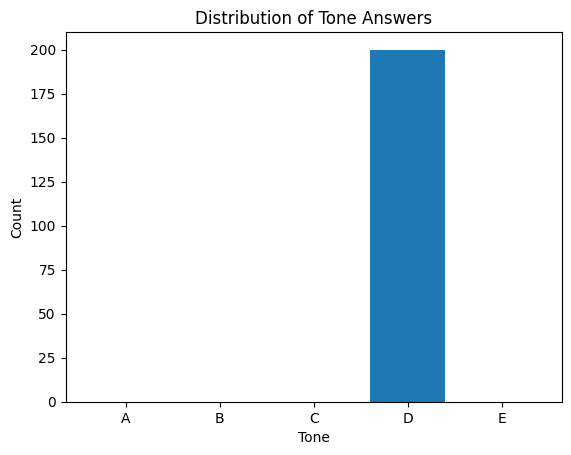

In [46]:
#bar graph of answers for quesyion 41
import matplotlib.pyplot as plt

def plot_tone_answers(articles):
    tones = ["A", "B", "C", "D", "E"]
    tone_counts = {tone: 0 for tone in tones}
    for article in articles:
        tone = article["Narrative_answers"]["41"]
        tone_counts[tone] += 1
    
    plt.bar(tone_counts.keys(), tone_counts.values())
    plt.xlabel("Tone")
    plt.ylabel("Count")
    plt.title("Distribution of Tone Answers")
    plt.show()

plot_tone_answers(articles)

In [25]:
#store summaries and lang of the above pairs in a csv file
import csv

def write_to_csv(pairs, articles, filename):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Article 1", "Article 2", "Language"])
        for pair in pairs:
            article1 = next(article for article in articles if article["uri"] == pair[0])
            article2 = next(article for article in articles if article["uri"] == pair[1])
            writer.writerow([article1["summary"], article2["summary"], article1["lang"], article2["lang"]])

write_to_csv(pairs, articles, "article_pairs.csv")


### Factor model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple


class FactorModel(nn.Module):
    def __init__(self, N: int, K: List[int], d: int):
        super(FactorModel, self).__init__()
        self.N = N  # Number of questions
        self.K = K  # List of number of categorical answers for each question
        self.d = d  # Latent dimension
        self.W = nn.ModuleList([nn.Linear(d, K[i] - 1, bias=False) for i in range(N)])
        self.biases = nn.ParameterList(
            [nn.Parameter(torch.randn(K[i] - 1)) for i in range(N)]
        )

    def forward(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = [self.W[n](v) + self.biases[n] for n in range(self.N)]
        # Append zero logits for the last category to each question's logits
        logits = [
            torch.cat((logit, torch.zeros(logit.size(0), 1).to(logit.device)), dim=1)
            for logit in logits
        ]
        return logits

    def predict_proba(self, v: torch.Tensor) -> List[torch.Tensor]:
        logits = self.forward(v)  # List of logits for each question
        probabilities = [torch.softmax(logit, dim=-1) for logit in logits]
        return probabilities


def loss_function(
    model: FactorModel,
    v: torch.Tensor,
    answers: torch.Tensor,
    lambda1: float,
    lambda2: float,
) -> torch.Tensor:

    criterion = nn.NLLLoss(reduction="sum")
    logits = model.forward(v)

    total_loss = 0
    for n in range(model.N):
        log_probs = nn.functional.log_softmax(logits[n], dim=1)
        total_loss += criterion(log_probs, answers[:, n])
    nll_loss = total_loss.clone()
    # L2 Regularization
    l2_reg = sum(torch.norm(W.weight, 2) ** 2 for W in model.W)
    total_loss += lambda1 * l2_reg
    total_loss += lambda2 * torch.norm(v, 2) ** 2
    return total_loss, nll_loss


def train_model(
    model: FactorModel,
    answers: torch.Tensor,
    epochs: int = 1000,
    lr: float = 0.01,
    lambda1: float = 0.01,
    lambda2: float = 0.01,
) -> Tuple[FactorModel, torch.Tensor]:

    v = torch.randn(len(answers), model.d, requires_grad=True)

    # optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(list(model.parameters()) + [v], lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, nllloss = loss_function(model, v, answers, lambda1, lambda2)
        loss.backward()
        optimizer.step()
        # if epoch % 100 == 0:
        # print(f"Epoch {epoch}, Loss: {loss.item()}, nll_loss: {nllloss.item()}")
    print(
        f"d: {model.d}, Epoch {epoch}, Loss: {loss.item()}, nll_loss: {nllloss.item()}"
    )
    return model, v

In [7]:
import json

with open("India_election_formatted_questions_200.json") as f:
    data = json.load(f)
Q = data.values()
K = []
for q in Q:
    choice = q["choices"].values()
    K.append(len(choice))

In [22]:
import json
import numpy as np


def extract_answers(file):
    with open(file) as f:
        data = json.load(f)

    # Initialize a list to store the extracted values
    answers = []

    # Iterate through the JSON objects to extract `post_LLM_answer`
    for item in data:

        if "Narrative_answers" in item:
            # get the value under the key `answers`
            answer = item["Narrative_answers"]
            answers.append(list(answer.values()))

    # convert the list of extracted values to a numpy array
    answers = np.array(answers)
    answers = np.where(answers == "A", 0, answers)
    answers = np.where(answers == "B", 1, answers)
    answers = np.where(answers == "C", 2, answers)
    answers = np.where(answers == "D", 3, answers)
    answers = np.where(answers == "E", 4, answers)
    answers = answers.astype(int)
    return answers

In [10]:
answers = []
answer = extract_answers("Combined_India_election_summary_Narrative_QnA_200.json")
answers.append(answer)
answers = np.array(answers)

# reshape answers to 600,80
answers = answers.reshape(200, 30)
answers.max()

4

In [11]:
print(K)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [12]:
ans_max = list(answers.max(axis=0) + 1)
for i in range(len(ans_max)):
    if ans_max[i] > K[i]:
        print(i + 1, ans_max[i], K[i])

In [15]:
import torch

answers = torch.tensor(answers, dtype=torch.long)

/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_59054/3054846765.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  answers = torch.tensor(answers, dtype=torch.long)


In [16]:
N = len(K)  # Number of questions

M = answers.shape[0]  # Number of articles

In [17]:
epo = 20000

for d in [3] + list(range(5, 41, 5)):

    model = FactorModel(N, K, d)
    trained_model, v = train_model(
        model, answers, epochs=epo, lr=0.01, lambda1=0.01, lambda2=0.01
    )
    # Extract the latent vectors v
    latent_vectors = v.detach().numpy()
    # save the latent vectors to csv file
    np.savetxt(
        f"latent_vectors_{d}.csv", latent_vectors, delimiter=","
    )

d: 3, Epoch 19999, Loss: 1834.0916748046875, nll_loss: 1723.071533203125
d: 5, Epoch 19999, Loss: 878.1597290039062, nll_loss: 712.2608032226562
d: 10, Epoch 19999, Loss: 102.87513732910156, nll_loss: 17.427501678466797
d: 15, Epoch 19999, Loss: 78.2104263305664, nll_loss: 11.515396118164062
d: 20, Epoch 19999, Loss: 72.21157836914062, nll_loss: 10.135868072509766
d: 25, Epoch 19999, Loss: 69.84247589111328, nll_loss: 9.543987274169922
d: 30, Epoch 19999, Loss: 68.87213134765625, nll_loss: 9.281026840209961
d: 35, Epoch 19999, Loss: 68.44046783447266, nll_loss: 9.141297340393066
d: 40, Epoch 19999, Loss: 68.30732727050781, nll_loss: 9.079283714294434


### Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import numpy as np

def v_2d_csv(filename,d):
    df = pd.read_csv(filename, header=None)
    data = df.values
    print(data.shape)
    tsne = TSNE(n_components=2, random_state=42)
    v_2d = tsne.fit_transform(data)
    print(v_2d.shape)
    df = pd.DataFrame(v_2d, columns=['x', 'y'])
    df.to_csv("v_2d_"+d+".csv", index=False)

def test_tsne_plot(filename,d):
    df = pd.read_csv(filename)
    data = df.values
    tsne = TSNE(n_components=2, random_state=42)
    v_2d = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    v_2d_english = v_2d[0:100]
    v_2d_hindi = v_2d[100:200]

    for index, (x, y) in enumerate(v_2d_english):
        plt.scatter(
            x, 
            y, 
            alpha=0.4, 
            color="blue",
            s=3, 
            label="English: India election" if index == 0 else "")

    for index, (x, y) in enumerate(v_2d_hindi):
        plt.scatter(
            x,
            y,
            alpha=0.4,
            color="green",
            s=3,
            label="Hindi: India Election" if index == 0 else "",
        )

    plt.title(
        f"t-SNE visualization of document embeddings \n {d} dimensions"
    )

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.legend()
    plt.show()

In [6]:
def interactive_tsne_plot(filename, combined_summary, d):
    # Load the 2D embeddings and the summaries
    v_2d_df = pd.read_csv(filename)
    v_2d_df["language"] = ["English"] * 100 + ["Hindi"] * 100
    # Example summary data (you should use the actual combined_summary data)
    v_2d_df["summary"] = [item["summary"].strip() for item in combined_summary]

    # Function to format summaries for hover text
    def format_summary(text: str) -> str:
        return text.replace("\n", "<br />")
    v_2d_df["formatted_summary"] = v_2d_df["summary"].apply(format_summary)
    
    # Create a color mapping for languages
    color_map = {
        "English": "blue",
        "Hindi": "red",
    }
    v_2d_df["color"] = v_2d_df["language"].map(color_map)

    # Create traces for each langauge
    traces = []
    for language in v_2d_df["language"].unique():
        df = v_2d_df[v_2d_df["language"] == language]
        trace = go.Scatter(
            x=df["x"],
            y=df["y"],
            mode="markers",
            name=f"{language}",
            marker=dict(color=color_map[language], size=8),
            customdata=df[["formatted_summary"]],
            hoverinfo="none",
            )
        traces.append(trace)

    # Create the layout
    layout = go.Layout(
        title=f"t-SNE Visualization of News Articles with dimension {d}",
        xaxis=dict(title="t-SNE component 1"),
        yaxis=dict(title="t-SNE component 2"),
        showlegend=True,
    )

    # Create the figure
    fig = go.Figure(data=traces, layout=layout)

    # Save the plot as an HTML file with embedded JavaScript and CSS
    html_content = f"""
    <html>
    <head>
        <title>Interactive Plot</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            #summary-box {{
                position: absolute;
                top: 10px;
                right: 10px;
                width: 400px;
                max-height: 600px;
                overflow-y: auto;
                background-color: white;
                border: 1px solid black;
                padding: 10px;
                z-index: 1000;
                white-space: pre-line;
            }}
        </style>
    </head>
    <body>
        <div id="plot">{fig.to_html(full_html=False, include_plotlyjs='cdn')}</div>
        <div id="summary-box">Hover over a point to see the summary here.</div>
        <script>
            document.addEventListener('DOMContentLoaded', function() {{
                const plotElement = document.querySelector('.plotly-graph-div');
                plotElement.on('plotly_hover', function(data) {{
                    if(data.points.length > 0) {{
                        const summary = data.points[0].customdata[0];
                        document.getElementById('summary-box').innerHTML = summary;
                    }}
                }});
                plotElement.on('plotly_unhover', function(data) {{
                    document.getElementById('summary-box').innerHTML = 'Hover over a point to see the summary here.';
                }});
            }});
        </script>
    </body>
    </html>
    """

    # Save the HTML content to a file
    with open("interactive_plot_" + d +".html", "w") as f:
        f.write(html_content)


(200, 3)
(200, 2)


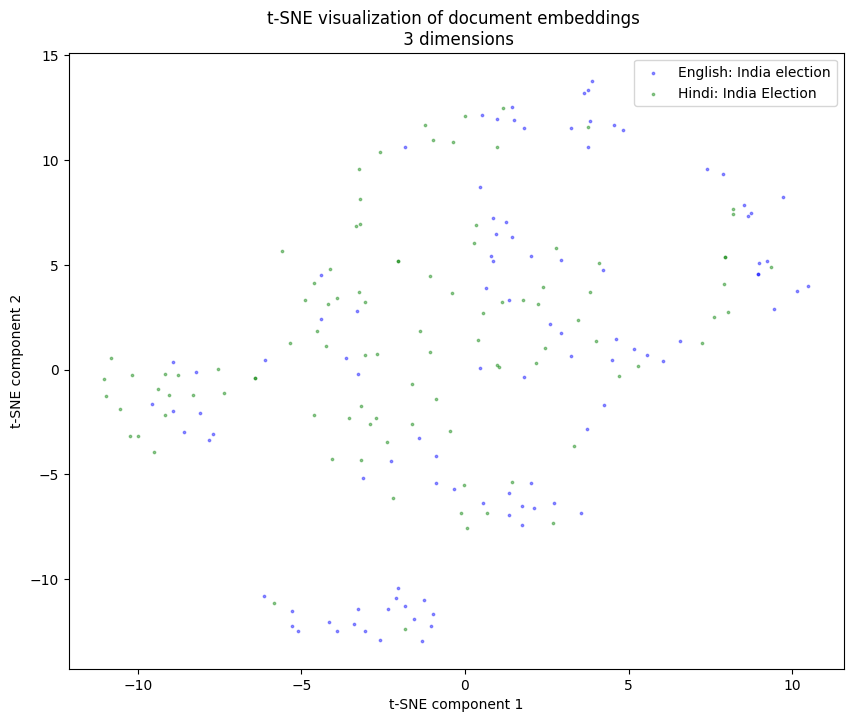

(200, 5)
(200, 2)


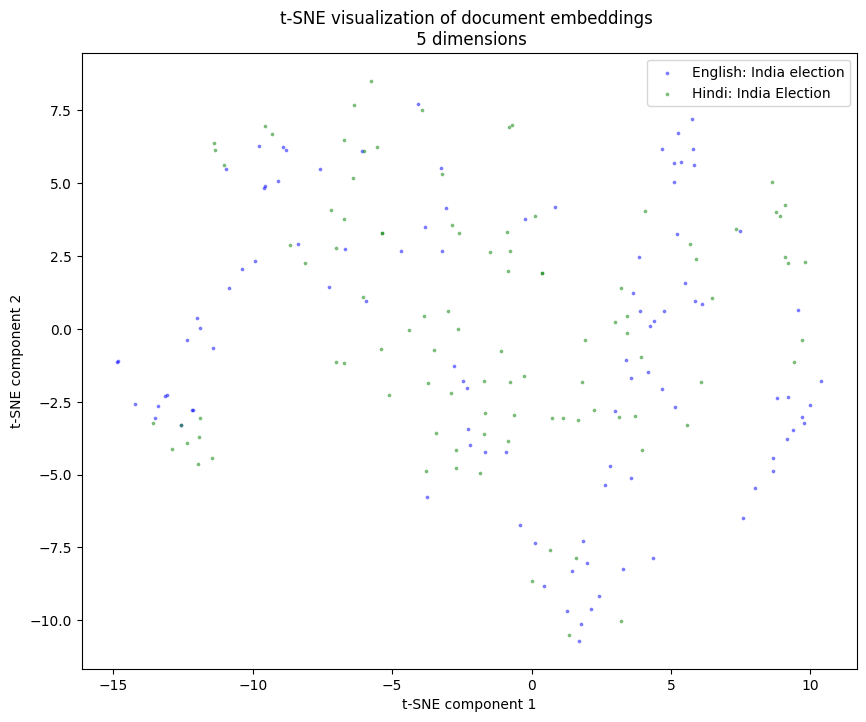

(200, 10)
(200, 2)


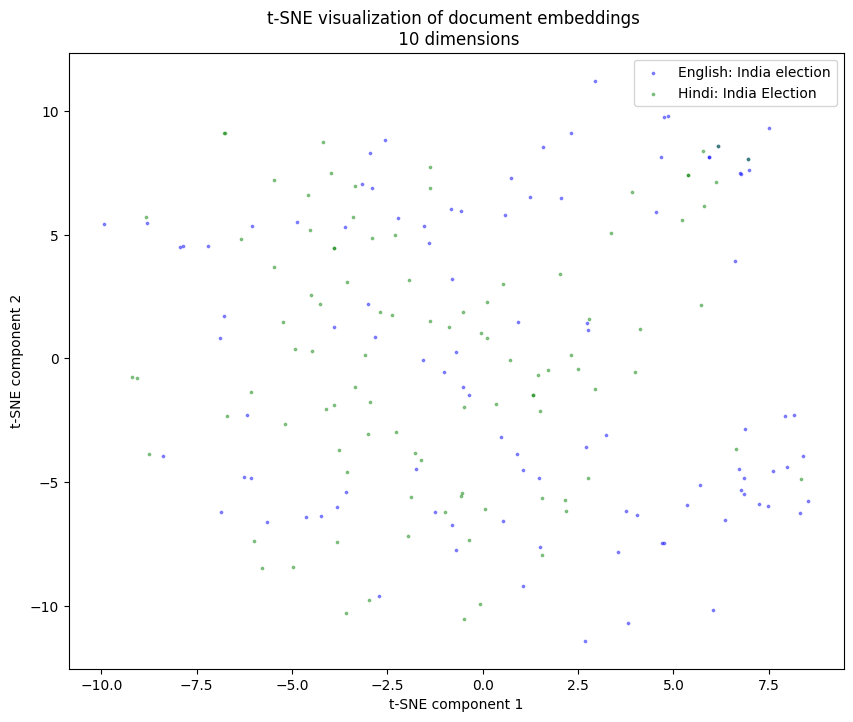

(200, 15)
(200, 2)


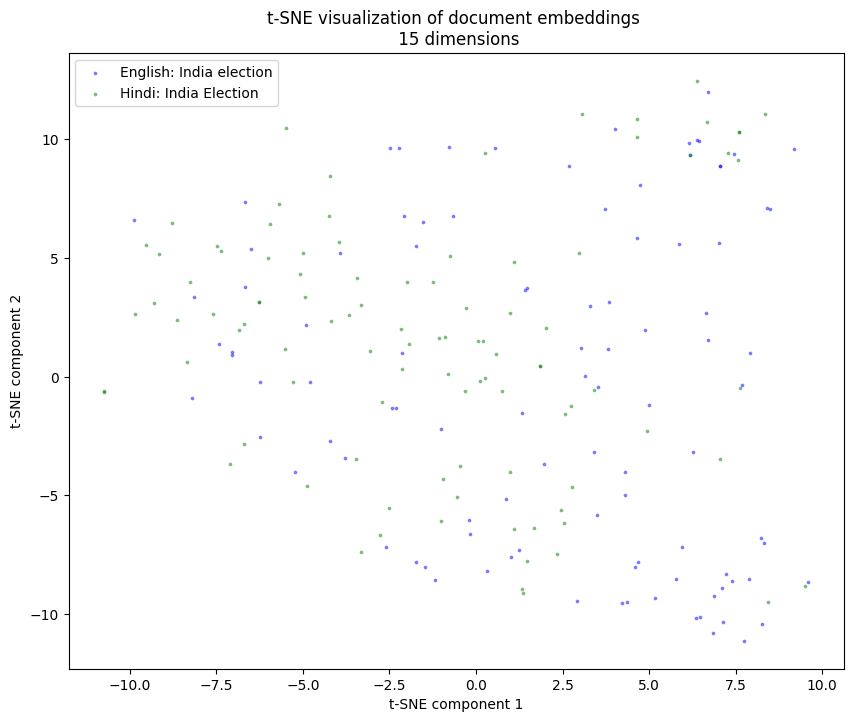

(200, 20)
(200, 2)


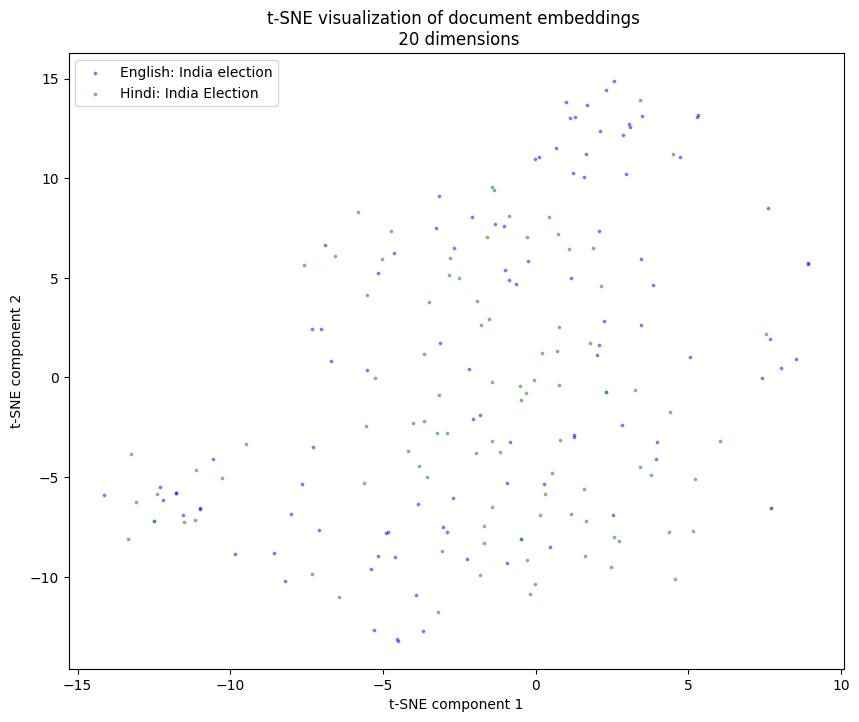

(200, 25)
(200, 2)


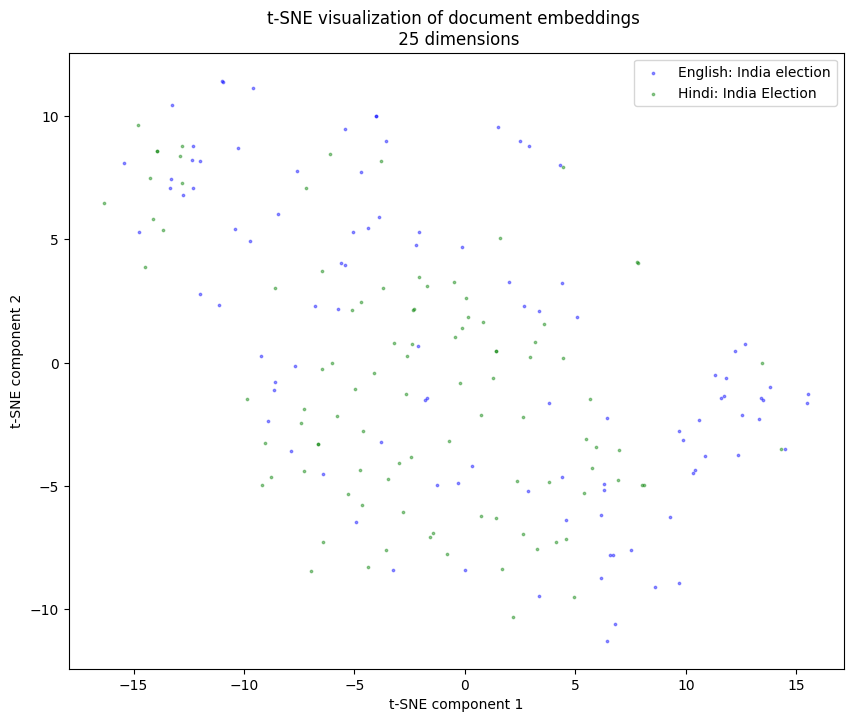

(200, 30)
(200, 2)


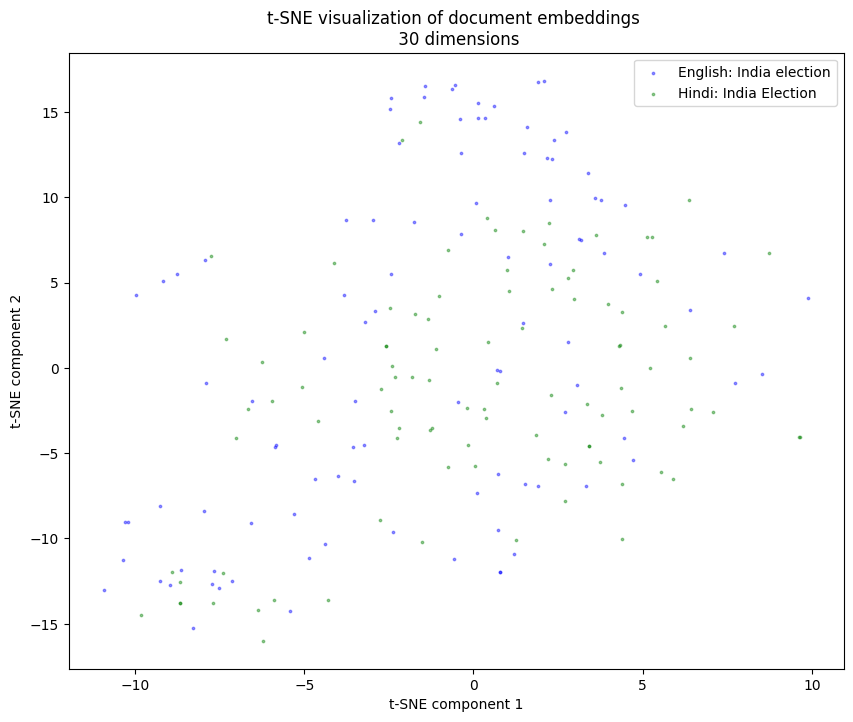

(200, 35)
(200, 2)


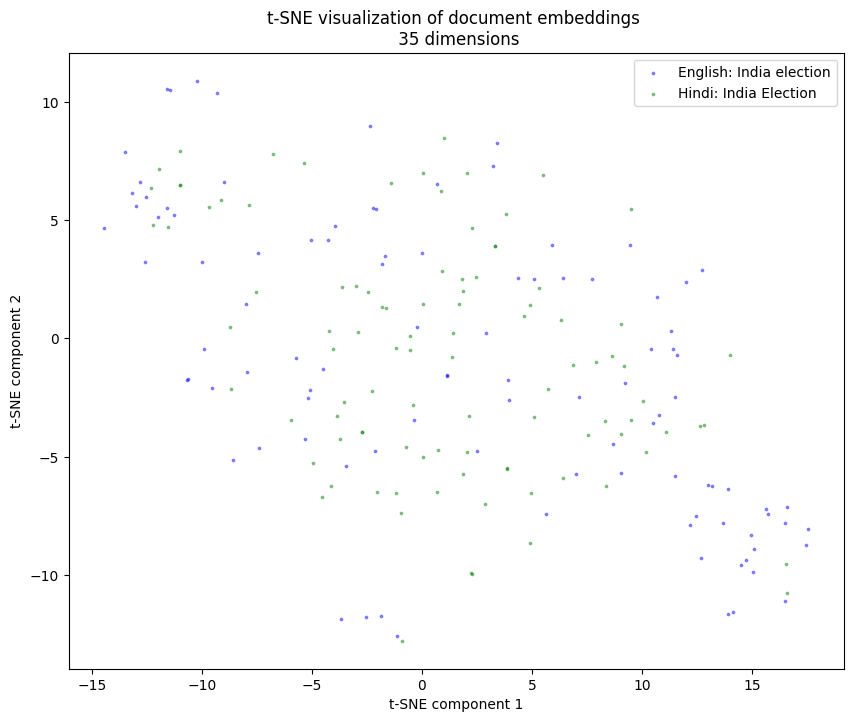

(200, 40)
(200, 2)


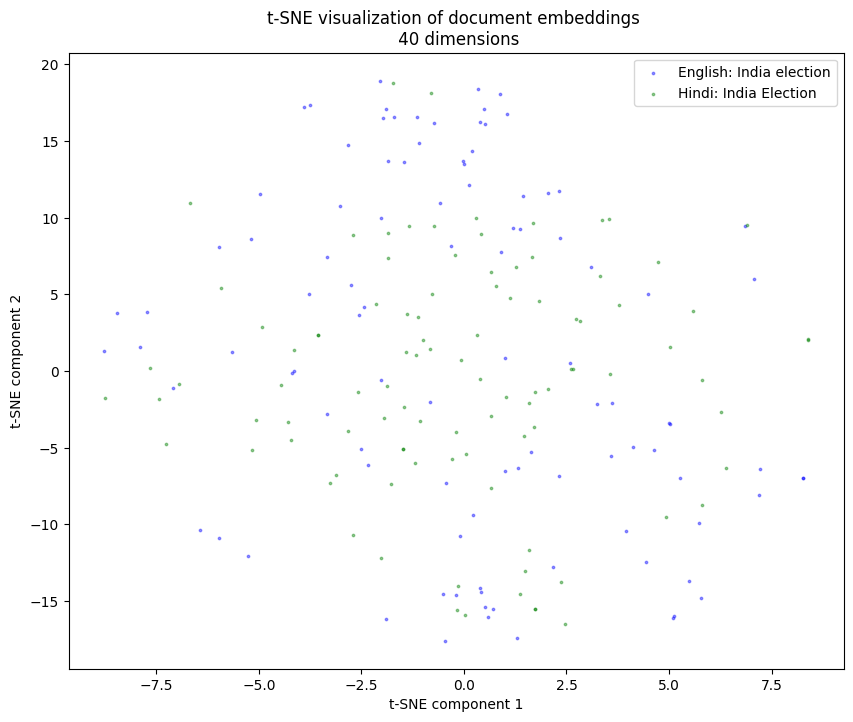

In [7]:
with open("Combined_India_election_summary_200.json", "r") as f:
    combined_summary = json.load(f)

dimensions = ["3","5","10","15","20","25","30","35","40"]
for d in dimensions:
    v_2d_csv("latent_vectors_" +d + ".csv",d)
    test_tsne_plot("latent_vectors_" +d +".csv",d)
    interactive_tsne_plot("v_2d_" +d+ ".csv",combined_summary,d)